<a href="https://colab.research.google.com/github/TomPhanAnh/Kaggle-Solution/blob/main/DaZone_Round2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# **ZALOPAY INTRODUCTION**

ZaloPay is an **E-wallet** established at the end of 2016 and is
part of Vietnamese unicorn VNG’s digital ecosystem, which
also includes gaming, media and cloud computing.

In January 2020, ZaloPay launched on Zalo platform, with the
aim to become the **“Vietnamese citizens’ E-wallet”.** ZaloPay
provides daily usage in-app services such as money transfer,
phone top-up, and paying bills. With a ready presence on local
users’ smartphones and robust product offerings, ZaloPay has
competitive advantages to become the champion e-wallet.

In May 2022, ZaloPay reached 10M active users, which was a
significant milestone. After a few years of traversing the
digital payment market, we have helped to foster a cashless
society by creating convenient payment methods for our
consumers' daily lives.

According to Circular 23/2019/TT-NHNN, each individual must accurately fill
out their personal information to validate their account and minimize risks
while making a payment. Before making payments for services, e-wallets must
be linked to the owner's bank account or debit card. As a result, ZaloPay has
always **prioritized the growth of associated banks and studying and optimizing
the flow of connecting banks to provide all clients with the most convenient
wallet.**

## **Context**

There are two systems of interest here: **front-end** and **back-end** systems. The **front-end system tracks **users’ interaction with the app (users stayed on
which screen, clicked on which button, at which time, etc.).The back-end
system** tracks the request in the back end that is created as a result of certain actions on the front-end. For example, when users clicked on the button “Mua ngay (buying immediately)” on an item, there’s a request on the backend at the same time and its status reflects whether users purchased successfully or not.

**For the front-end dataset:** Each screen in the product flow that you will
investigate in this assignment has its ID. The at-issues screens are numbered
from 11 to 18, where Screen 11 is the beginning of the flow where users will fill out their bank account info and click “Lien ket ngay (link immediately)” (see the illustrative at the end of the assignment). Screens 12 to 18 reflect different meanings (e.g. the outcomes of the “Lien ket ngay” action, and our
corresponding features for various outcomes).

**For the back-end dataset:** when users click “Liên kết ngay” on screenID 11,
a request will be recorded in the backend.csv. There are a lot of statuses here, but the one of interest is “-FACJ” status and “B”. When users encounter the “-FACJ” error, they will interact with another flow.

We are testing two UIs for users who encounter “-FACJ” error. Let’s call these
“new UI” and “old UI”. Only a subset of users can see the new UI, which includes
screenID 12, 13, 14, 15, 16, 17, 18. The old UI does not have an associated screenID, so it temporarily assumes users that have “-FACJ” error but don’t see screenID 12 through 18 will see the old UI.

The old UI and new UI are expected to help users retry and, hopefully, succeed.
Users that finish interacting with the flow after “-FACJ” will come back to
screenID 11 and submit another request to backend.csv. A successful request has
a “B” status.

**Preprocessing dataset**

In [8]:
front_end = pd.read_csv("Front-end dataset.csv",delimiter = " ")
front_end = front_end['eventid\tid\tscreenid\ttimestamp\t\t\t,'].str.split("\t",expand = True)
front_end.drop([4,5,6], axis = 1, inplace = True)
front_end.columns = ["eventid","id","screenid","timestamp"]

In [9]:
def remove_comma(x):
  if "'" in x:
    return x.replace("'"," ").strip()
  else:
    return x
front_end["id"] = front_end["id"].apply(lambda x: remove_comma(x))
front_end["screenid"] = front_end["screenid"].apply(lambda x: remove_comma(x))
front_end["timestamp"] = front_end["timestamp"].apply(lambda x: remove_comma(x))

In [10]:
front_end["timestamp"] = pd.to_datetime(front_end["timestamp"],unit = "ms")

In [11]:
front_end.drop_duplicates(inplace = True)

## **Backend Dataset**

In [383]:
back_end = pd.read_csv("Back-end dataset.csv")
back_end = back_end['timestamp\tstepresult\tid'].str.split("\t",expand = True)
back_end.rename(columns = {0:"timestamp",1:"stepresult",2:"id"}, inplace =True)
back_end["timestamp"] = pd.to_datetime(back_end['timestamp'], unit = 'ms')

## **Merging Dataset**

In [62]:
count_front = front_end.groupby(["id","screenid","eventid"]).agg({"eventid":"count"}).reset_index(level = [0,1])
max_front = count_front.groupby(["id","screenid"]).agg({"eventid":"max"}).reset_index().sort_values(["id","screenid"])

In [63]:
count_front.rename(columns = {"eventid":"count"},inplace = True)
count_front = count_front.reset_index()

In [64]:
merge_data = count_front.merge(front_end,on = ["eventid","id"], how = "right")
merge_data["screenid_x"] = merge_data["screenid_x"].astype("int64")

In [65]:
max_front

,id,screenid,eventid
0,BAAAFACIBHCHHCCCAFH,11,1
1,BAAAFFHHEDJFEAAFG,11,3
2,BAABEBCJFBFDAGCHFAA,11,1
3,BAACEAADIJBJJCDDIII,11,1
4,BAACFAHHCDFIHAAACCG,11,1
...,...,...,...
16260,JJJGCDCEEGBJJJJGCAH,17,1
16261,JJJGFBFFJFAGDJFFHJC,11,1
16262,JJJHEDCDGGIFGHJGCCF,11,2
16263,JJJHHHEEFEJHEBAFFCC,11,2


In [68]:
# Create the dataset for screenid == 11
merge_data11 = merge_data.loc[merge_data["screenid_x"] == 11]
new_data = pd.DataFrame(columns = merge_data.columns)
for i in merge_data11["id"].value_counts().index:
  
  # Test the condition to take the most interactive eventid of old UI
  count = max(merge_data11.loc[(merge_data11["id"] == i)]["count"])
  eventid = merge_data11.loc[(merge_data11["id"] == i ) & 
                           (merge_data11["count"] == count)].sort_values(["timestamp","eventid"])["eventid"].value_counts().index[0]

  # Concatenate the Data with condition
  df = merge_data11.loc[(merge_data11["id"] == i) & 
                 (merge_data11["eventid"] == eventid)]  
            
  new_data = pd.concat([df,new_data])

In [69]:
# Create the dataset for screenid != 11
merge_data1218 = merge_data.loc[merge_data["screenid_x"] != 11]
new_data1218 = pd.DataFrame(columns = merge_data.columns)
for i in merge_data1218["id"].value_counts().index:

  # Test the condition to take the most interactive eventid of new UI
  count = max(merge_data1218.loc[(merge_data1218["id"] == i)]["count"])
  eventid = merge_data1218.loc[(merge_data1218["id"] == i ) & 
                           (merge_data1218["count"] == count)].sort_values(["timestamp","eventid"])["eventid"].value_counts().index[0]

  # Concatenate the Data with condition
  df = merge_data1218.loc[(merge_data1218["id"] == i) & 
                 (merge_data1218["eventid"] == eventid)]  
            
  new_data1218 = pd.concat([df,new_data1218])

In [70]:
# Concate to get timestamp for each loop
data_Q1 = pd.concat([new_data,new_data1218])

# **Task 1:Prepare a report that answers the following questions**

### **Q1. What is the retry rate for each UI? Does the new UI improve the retry rate?**

**Retry rate** = max(0,n_screen11 - n_screen1218 - 1)/

( max(0,n_screen11 - n_screen1218 - 1)+ n_screen1218)


**n_screen11:** the number of times UI log in

**n_screen1218:** the maximum number of times UI in each screen12 - 18 

*(**Assume:** user is interactive with several screen, the screen with the most use is chosen and 1 unit of other screen is equal as 1 unit of screen 11)*

In [71]:
# What is the retry rate for each UI? 
# 1 is new
# 0 is old
Q1 = data_Q1.drop_duplicates(["id","screenid_x"])

# create the dataframe to check UI old or new
question1 = pd.DataFrame(data_Q1["id"].value_counts().index, columns = ["id"])
question1["screen11"] = 0
question1["screen1218"] = 0


In [72]:
# Fill the dataset specified with each id (user)
for i in question1["id"].values:
  question1.loc[question1["id"] == i, "screen11"] = max_front.loc[(max_front["screenid"] == "11") & (max_front["id"] == i)]["eventid"].values
  try:
    question1.loc[question1["id"] == i, "screen1218"] = max(max_front.loc[(max_front["screenid"] != "11") & (max_front["id"] == i)]["eventid"].values)
  except:
    pass

In [73]:
# Define UI (New or Old)
question1["UI"] = question1.apply(lambda x: 1 if x["screen1218"] > 0 else 0, axis = 1)
question1["screen11"] = question1["screen11"].astype("int64")
question1["screen1218"] = question1["screen1218"].astype("int64")

# Calculate retry rate for each UI
# In case New UI enter in screen12 to screen 18 more than log-in (screen11) => no retry rate = 0
# Else New UI enter in screen12 to screen 18 less than log-in (screen11)    => retry rate is available
# The last time is not a retry (-1)
question1["retry_times"] = question1.apply(lambda x: max(0,x["screen11"] - x["screen1218"] - 1), axis = 1)

# retry rate of new_UI
new_iu_retry = sum(question1.loc[question1["UI"] == 1]['retry_times'])/(
                sum(question1.loc[question1["UI"] == 1]['retry_times']) 
              + sum(question1.loc[question1["UI"] == 1]["screen1218"]))

# Suppose the last time of old Ui does mean they stop => the last eventid doesn't mean a retry but a stop => don't include in the number of retry

# retry rate of old_UI
old_iu_retry = (sum(question1.loc[question1["UI"] == 0]['screen11']) -
                len(question1.loc[question1["UI"] == 0]['screen11']))/sum(question1.loc[question1["UI"] == 0]['screen11'])

In [74]:
print("The retry rate of New UI: {}".format(round(new_iu_retry,2)))
print("The retry rate of Old UI: {}".format(round(old_iu_retry,2)))

The retry rate of New UI: 0.1
The retry rate of Old UI: 0.43


**Q1.2: Does the new UI improve the retry rate?**

In [75]:
# Create the hour interval for frontend dataset
front_end["Year"]  = front_end["timestamp"].apply(lambda x: x.year)
front_end["Month"] = front_end["timestamp"].apply(lambda x: x.month)
front_end["Day"]   = front_end["timestamp"].apply(lambda x: x.day)
front_end["Hour"]  = front_end["timestamp"].apply(lambda x: x.hour)
front_end["timestamp2"] = front_end.apply(lambda x: pd.datetime(x["Year"],x["Month"],x["Day"],x["Hour"]), axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [76]:
Q12 = front_end.merge(question1[["id","UI"]], on = "id", how = "right")

In [77]:
Q12.head()

,eventid,id,screenid,timestamp,Year,Month,Day,Hour,timestamp2,UI
0,"x,11.xy1",FFDBDJFJGCIJHBBACIA,11,2021-03-15 08:17:27.824,2021,3,15,8,2021-03-15 08:00:00,1
1,"x,14.06",FFDBDJFJGCIJHBBACIA,14,2021-03-15 08:39:23.532,2021,3,15,8,2021-03-15 08:00:00,1
2,"x,11.xy0",FFDBDJFJGCIJHBBACIA,11,2021-03-15 08:17:28.822,2021,3,15,8,2021-03-15 08:00:00,1
3,"x,11.xy1",FFDBDJFJGCIJHBBACIA,11,2021-03-15 08:42:56.675,2021,3,15,8,2021-03-15 08:00:00,1
4,"x,14.06",FFDBDJFJGCIJHBBACIA,14,2021-03-15 08:43:10.081,2021,3,15,8,2021-03-15 08:00:00,1


In [78]:
Q12_sc11 = Q12.loc[(Q12["screenid"] == "11") 
                   & (Q12["UI"] == 1)].groupby(
                  by = ["timestamp2"]).count().reset_index()[["timestamp2","eventid"]].rename(columns = {"eventid":"screen11"})

In [79]:
Q12_sc1218 = pd.DataFrame(columns = ["timestamp2","eventid"])
table = Q12.loc[(Q12["screenid"] != "11") 
              & (Q12["UI"] == 1)].groupby(by = ["timestamp2","screenid"]).count().reset_index()

for i in table['timestamp2'].unique():        
  a = max(table.loc[table['timestamp2'] == i]["eventid"])
  table_x = table.loc[(table['timestamp2'] == i) 
                    & (table["eventid"] == a)][["timestamp2","eventid"]]
  Q12_sc1218 = pd.concat([Q12_sc1218,table_x]) 

In [80]:
Q12_sc1218.rename(columns = {"eventid":"screen1218"},inplace = True)

In [81]:
Q12_answer = Q12_sc11.merge(Q12_sc1218, on = "timestamp2", how = "left").fillna(0)
Q12_answer["retry_times"] = Q12_answer.apply(lambda x: max(0, x["screen11"] - x["screen1218"]), axis = 1)
Q12_answer["retry_rate"]  = Q12_answer.apply(lambda x: (x["retry_times"] - 1)/(x["retry_times"] + x["screen1218"]),axis = 1)
Q12_answer.drop(["screen11","screen1218"], axis = 1, inplace = True)

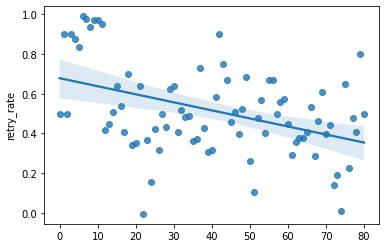

In [82]:
# Visualization of New UI by 1 hour interval from dataset with regression line
sns.regplot(x = Q12_answer.index, y = "retry_rate", data = Q12_answer)

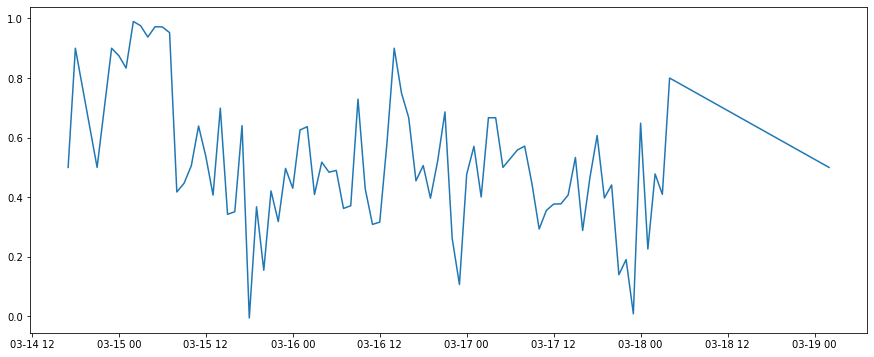

In [83]:
# Visualization of New UI by 1 hour interval from dataset with line chart
fig = plt.figure(figsize = (15,6))
plt.plot(Q12_answer["timestamp2"], Q12_answer["retry_rate"])

### **Q2. Among the people who retried, what is the success rate for each UI? Does the new UI improve the success rate?**

**Success rate** = min(n_success, n_enter)/n_enter

**n_success:** The number of time UI successfully reaches to screenID 12 - 18

**n_enter  :** The total number of time UI enter in screen 11

In [84]:
question1["success_times"] = question1.apply(lambda x: min(x["screen1218"],x["screen11"]), axis = 1)
question1["success_rate"]  = question1.apply(lambda x: x["success_times"]/x["screen11"], axis = 1)

In [85]:
new_iu_success = sum(question1.loc[question1["UI"] == 1]['success_times'])/(sum(question1.loc[question1["UI"] == 1]["screen11"]))
old_iu_success = sum(question1.loc[question1["UI"] == 0]['success_times'])/(sum(question1.loc[question1["UI"] == 0]["screen11"]))

In [86]:
print("The success rate of New UI: {}".format(round(new_iu_success,2)))
print("The success rate of Old UI: {}".format(old_iu_success))

The success rate of New UI: 0.75
The success rate of Old UI: 0.0


**Q2.2. Does the new UI improve the success rate?**

In [87]:
Q22 = Q12_sc11.merge(Q12_sc1218, on = "timestamp2", how = "left").fillna(0)
Q22.head()

,timestamp2,screen11,screen1218
0,2021-03-14 17:00:00,2,0
1,2021-03-14 18:00:00,10,0
2,2021-03-14 21:00:00,2,0
3,2021-03-14 23:00:00,10,0
4,2021-03-15 00:00:00,8,0


In [88]:
Q22["success_times"] = Q22.apply(lambda x: min(x["screen1218"],x["screen11"]), axis = 1)
Q22["success_rate"]  = Q22.apply(lambda x: x["success_times"]/x["screen11"], axis = 1)
Q22.drop(["screen11","screen1218"], axis = 1, inplace = True)

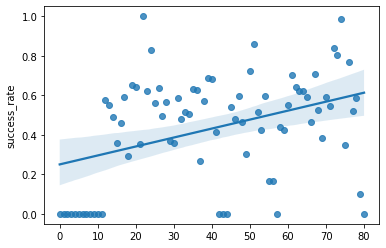

In [89]:
# Visualization of New UI by 1 hour interval from dataset
sns.regplot(x = Q22.index, y = "success_rate", data = Q22)

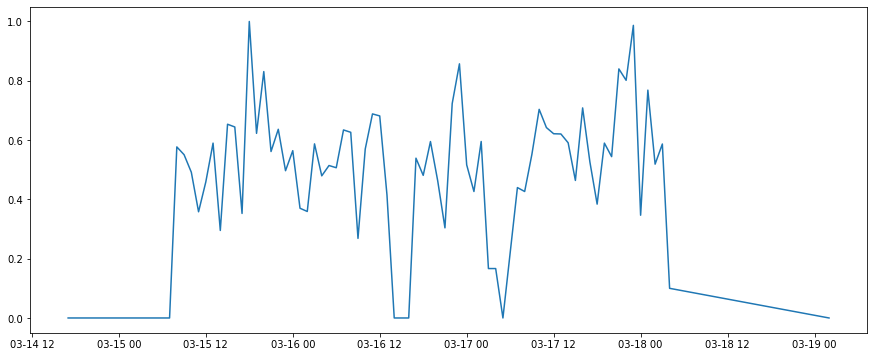

In [90]:
# Visualization of New UI by 1 hour interval from dataset with line chart
fig = plt.figure(figsize = (15,6))
plt.plot(Q22["timestamp2"], Q22["success_rate"])

###**Q3. What is the distribution of requests by the error for each UI? Does the new UI help reduce FACJ error?**

**Q3.1 What is the distribution of requests by the error for each UI?**

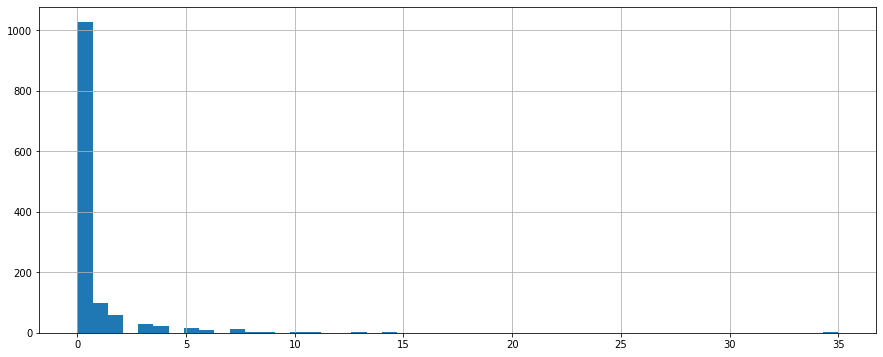

In [91]:
Q31 = question1.copy()
# Visualize The distribution in term of retry times of New UI (UI = 1)
fig = plt.figure(figsize = (15,6))
Q31.loc[Q31["UI"] == 1]["retry_times"].hist(bins = 50)

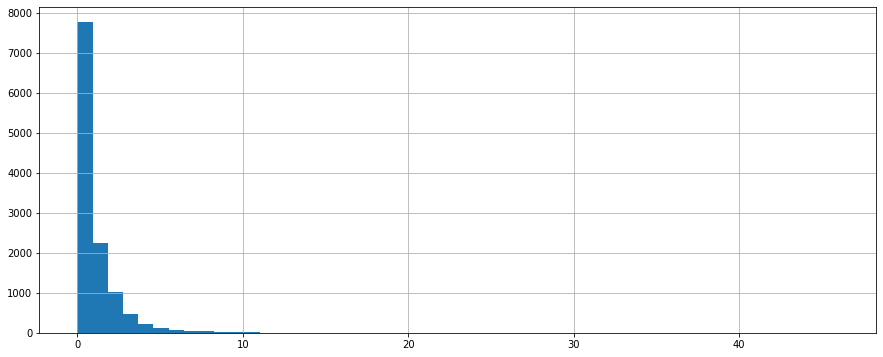

In [92]:
Q31 = question1.copy()
# Visualize The distribution in term of retry times of Old UI (UI = 0)
fig = plt.figure(figsize = (15,6))
Q31.loc[Q31["UI"] == 0]["retry_times"].hist(bins = 50)

**Q.3.2.Does the new UI help reduce FACJ error?**

In [93]:
pd.concat([Q31.loc[Q31["UI"] == 0]["retry_times"].describe().to_frame().rename(columns = {"retry_times":"Old UI"}),
           
           Q31.loc[Q31["UI"] == 1]["retry_times"].describe().to_frame().rename(columns = {"retry_times":"New UI"})], axis = 1)

,Old UI,New UI
count,12090.000000,1279.000000
mean,0.762200,0.551212
std,1.638253,1.727617
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,46.000000,35.000000


### **Q4. Among users that have eventid “x,13.02” , what is the ratio that has “x,14.05”**

In [94]:
len(front_end.loc[(front_end["eventid"] == "x,13.02") & (front_end["id"] == "BFHEHIDBJEJDABIAFBE")])

5

In [95]:
Q4 = pd.DataFrame(columns = ["id","x,13.02","x,14.05"])
Q4['id'] = front_end[front_end["eventid"] == "x,13.02"]["id"].value_counts().index


In [96]:
for i in Q4["id"].values:
  Q4.loc[Q4["id"] == i , "x,13.02"] = len(front_end.loc[(front_end["eventid"] == "x,13.02") & (front_end["id"] == i)])
  try:
    Q4.loc[Q4["id"] == i , "x,14.05"] = len(front_end.loc[(front_end["eventid"] == "x,14.05") & (front_end["id"] == i)])
  except:
    pass

In [97]:
# Column available indicates 1 if x,14.05 in eventid: x,13.02 
Q4["available"] = Q4.apply(lambda x: 1 if min(x["x,13.02"],x["x,14.05"]) > 0 else 0, axis = 1)

In [98]:
ratio = Q4["available"].value_counts()[1]/sum(Q4["available"].value_counts())
print("Among users that have eventid “x,13.02” , the ratio that has “x,14.05” is: {}".format(round(ratio,2)))

Among users that have eventid “x,13.02” , the ratio that has “x,14.05” is: 0.72


**Q5. Do we keep or remove this product feature (new UI)? If we keep it, what
should be optimized?**

# **Task 2: Additionally, do the following ad-hoc checks on the data (no need to include these in the report, but good to include in the summary email)**

**Q1. In metadata.csv, extract the bank code from metadata column.**
For example, >>> '{"timeStamp":1628391863136, "osType":2, "bankCode":"AHG"}' AHG

**How many unique banks are there?**

In [99]:
metadata = pd.read_csv("Meta dataset.csv")
metadata = metadata["metadata"].str.split(",",expand = True)
metadata.columns = ["timestamp","osType","bankcode"]
# Extract data from row with string technique
metadata["timestamp"] = metadata["timestamp"].apply(lambda x: int(x[-13:]))
metadata["osType"]    = metadata["osType"].apply(lambda x: int(x[-1:]))
metadata["bankcode"]  = metadata["bankcode"].apply(lambda x: x[-5:-2].upper())

In [100]:
metadata.loc[metadata["bankcode"] == '"RG', "bankcode"] = "RG"

In [101]:
print("The number of Unique bank are: {}".format(len(metadata["bankcode"].value_counts())))

The number of Unique bank are: 39


**Q2. In backend.csv, determine the year, month, and date of the log.**

-FACJ1 > B1 > -FACJ2 > B2

**Then their weighted time will be the average of -FACJ1 to B1 and -FACJ2 to B2.**

In [384]:
# Drop duplicates
back_end.drop_duplicates(["timestamp","id"],inplace = True)

# Remove id has only 1 row because the average time is calculated only when 2 or more rows are availble
# index with only 1 row are 
new = back_end["id"].value_counts()[back_end["id"].value_counts() == 1].index

back_end = back_end.set_index("id").drop(new, axis = 0).reset_index()

In [385]:
# shift_day is the function working as shift day back 1 day of 1 UI
def shift_day(x,y,z):
  if x != y:
    return None
  else:
    return z

# Shift status is the function to work as shift status back 1 day of 1 UI
def shift_status(x,y,z):
  if x != y:
    return None
  else:
    return z

# return accept is the function to define status "B" or status "FACJ"
def return_accept(id,timestamp,timestamp1):
  if pd.isnull(timestamp1):
    accept = front_end.loc[(front_end["id"] == id) & (front_end["timestamp"] <= timestamp)]["screenid"].nunique()
  else:
    accept = front_end.loc[(front_end["id"] == id) & (front_end["timestamp"] >= timestamp1) & (front_end["timestamp"] <= timestamp)]["screenid"].nunique()
  if accept > 1:
    return "B"
  else:
    return "FACJ"
# weighted_time is to calculate the weighted time of each UI
def weighted_time(x,y,z,t):
  if x == "B":
    if y == "FACJ":
      return z - t
    else:
      return None
  else:
    return None



In [386]:
# Calculate the exact day for each UI
back_end["id_1"] = back_end["id"].shift(1)
back_end["timestamp_1"] = back_end["timestamp"].shift(1)
back_end["timestamp_1"] = back_end.apply(lambda x: shift_day(x["id"],x["id_1"],x["timestamp_1"]),axis = 1)

# Redefince the stepresult columns
back_end["stepresult"] = back_end.apply(lambda x: return_accept(x["id"],x["timestamp"],x["timestamp_1"]), axis = 1)

# Create the stepresult back 1 days to check weighted time
back_end["stepresult_1"] = back_end["stepresult"].shift(1)
back_end["stepresult_1"] = back_end.apply(lambda x: shift_status(x["id"],x["id_1"],x["stepresult_1"]), axis = 1)

In [387]:
import time 

# remove null row of data
back_end = back_end.dropna(axis = 0)
back_end["timestamp"] = back_end["timestamp"].apply(lambda x: time.mktime(x.timetuple())*1000)
back_end["timestamp_1"] = back_end["timestamp_1"].apply(lambda x: time.mktime(x.timetuple())*1000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [388]:
back_end_T22 = pd.DataFrame(columns = [i for i in back_end.loc[back_end["stepresult"] == "B"]["id"].unique()])
back_end_T22["time_values"] = 0
back_end_T22["time_values"] = np.arange(0,10)
for i in back_end_T22.columns[:-1]:
  back_end_T22[i] = None

In [389]:
for x,y in zip([i for i in back_end_T22.columns[:-1]],range(len(back_end_T22.columns[:-1]))):
  table  = back_end.loc[back_end["id"] == x]
  number = len(table)
  for j in range(number):
    table_T22 = table.iloc[j]
    back_end_T22.iloc[j,y] = weighted_time(table_T22["stepresult"],table_T22["stepresult_1"],table_T22["timestamp"],table_T22["timestamp_1"])
  
# Transpose dateset back_end_T22
back_end_T22  = back_end_T22.T

In [406]:
back_end_T22 = back_end_T22.reset_index().rename(columns = {"index":"UI"})
back_end_T22 = back_end_T22.groupby(by = "UI").mean()
back_end_T22["average"] = back_end_T22.mean(axis=1,numeric_only=True,skipna=True)
back_end_T22["average"] = pd.to_datetime(back_end_T22["average"], unit = "ms")

,0,1,2,3,4,5,6,7,8,9,average
UI,,,,,,,,,,,
BAFGBAFAIEIFGHIHEDE,10000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-01 02:46:40.000000
BBCEJCIGEICBADCJHBB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
BFDDCBJCIJAFIDDHFJI,20000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-01 05:33:20.000000
BFHEHIDBJEJDABIAFBE,10000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-01 02:46:40.000000
BICDJCEGCAIHCHBHDBH,10000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-01 02:46:40.000000
BJABICBDACIJGCGBAF,10000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-01 02:46:40.000000
CAEBDHGIJICFFJBCDAB,40000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-01 11:06:40.000000
CBABGJGGCJFDHBEEHBD,20000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-01 05:33:20.000000
CBDACBFIEEFFAGHIHJH,30000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-01 08:20:00.000000


In [357]:
back_end_T22

,0,1,2,3,4,5,6,7,8,9,average
BBCEJCIGEICBADCJHBB,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CFFCJGJEJHDAFEIHBBB,10000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FBHGGHHIEIBHHHGGDAA,10000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
JAFAAJHFGCHDFCFFJCD,20000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HDHFBHJDAGBBCDFEJJC,10000000.0,10000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHDDDBJDDFECIBAFBCF,None,10000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DJAFCBCGBDIBIEIBGJC,10000000.0,40000000.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
JFCHIGJCDDHADCFAIJF,None,40000000.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GFHGIEIDAHGCDBCABJC,10000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FJHEFJHEIAACIDECFBC,10000000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [293]:
table  = back_end[back_end["id"] == "CHDDDBJDDFECIBAFBCF"]
number = len(table)
table_T22 = table.iloc[1,:]
back_end_T22.iloc[1,0] = weighted_time(table_T22["stepresult"],table_T22["stepresult_1"],table_T22["timestamp"],table_T22["timestamp_1"])

In [244]:
back_end_T22.iloc[1,0]

1

In [243]:
back_end_T22.iloc[0,1]

nan

In [239]:
back_end_T22["BBCEJCIGEICBADCJHBB"] = np.arange(10)

In [181]:
back_end_T22.iloc[0,0]

2

In [138]:
back_end.head()

,id,timestamp,stepresult,Year,Month,Day,Hour,timestamp2,id_1,timestamp_1
0,HGFEBEFGHIIHDEGFDBD,2021-03-15 09:20:00,FACJ,2021,3,15,9,2021-03-18 01:00:00,NaN,NaT
1,HGFEBEFGHIIHDEGFDBD,2021-03-15 12:06:40,FACJ,2021,3,15,12,2021-03-18 01:00:00,HGFEBEFGHIIHDEGFDBD,2021-03-15 09:20:00
2,DFEFAFIHBEABABDHHHF,2021-03-15 01:00:00,FACJ,2021,3,15,1,2021-03-17 13:00:00,HGFEBEFGHIIHDEGFDBD,NaT
3,DFEFAFIHBEABABDHHHF,2021-03-15 03:46:40,FACJ,2021,3,15,3,2021-03-17 13:00:00,DFEFAFIHBEABABDHHHF,2021-03-15 01:00:00
4,IBDBCJICJECEDDCEFGJ,2021-03-15 20:26:40,FACJ,2021,3,15,20,2021-03-17 13:00:00,DFEFAFIHBEABABDHHHF,NaT


In [139]:
back_end_T22

,BBCEJCIGEICBADCJHBB,CFFCJGJEJHDAFEIHBBB,BAEDEFHHAFAHDAFJDAE,FBHGGHHIEIBHHHGGDAA,JAFAAJHFGCHDFCFFJCD,HDHFBHJDAGBBCDFEJJC,CHDDDBJDDFECIBAFBCF,DJAFCBCGBDIBIEIBGJC,JFCHIGJCDDHADCFAIJF,DBJIGCAADIDDFJFIAJB,...,JIABHGCAEAIJJGIEBCI,CBABGJGGCJFDHBEEHBD,BJABICBDACIJGCGBAF,IEJDHCBAFEHEICCFCDH,DGEFGIJCJJBDJCEEEAG,GBJAJIBJGJGAHBIDCCI,CAEBDHGIJICFFJBCDAB,FEHGEJBDGHDDAHFFFBD,GJGCIIGCCDBGBFDBBDB,HFABHCJGGJIFDCDDHJJ


In [132]:
back_end.loc[back_end["id"] == 'JAFAAJHFGCHDFCFFJCD']

,id,timestamp,stepresult,Year,Month,Day,Hour,timestamp2,id_1,timestamp_1
49,JAFAAJHFGCHDFCFFJCD,2021-03-16 04:46:40,FACJ,2021,3,16,4,2021-03-17 08:00:00,JAHGBAHGAFFJGCGBCBA,NaT
50,JAFAAJHFGCHDFCFFJCD,2021-03-16 10:20:00,B,2021,3,16,10,2021-03-17 08:00:00,JAFAAJHFGCHDFCFFJCD,2021-03-16 04:46:40


In [130]:
back_end.loc[back_end["stepresult"] == "B"]["id"].unique()

array(['BBCEJCIGEICBADCJHBB', 'CFFCJGJEJHDAFEIHBBB',
       'BAEDEFHHAFAHDAFJDAE', 'FBHGGHHIEIBHHHGGDAA',
       'JAFAAJHFGCHDFCFFJCD', 'HDHFBHJDAGBBCDFEJJC',
       'CHDDDBJDDFECIBAFBCF', 'DJAFCBCGBDIBIEIBGJC',
       'JFCHIGJCDDHADCFAIJF', 'DBJIGCAADIDDFJFIAJB',
       'GFHGIEIDAHGCDBCABJC', 'FJHEFJHEIAACIDECFBC', 'DJEIICFIHDJJIHJGJA',
       'CGBBIGFHGCDHIEABGCA', 'IBCJHHCGIBGHGFHBFDB',
       'CDGFFGBGDHHDCJIFACD', 'JGEEACEAGBHBCGBAJCE',
       'HJEBACCJDFCIGFJAHDJ', 'HBDIHFFBDDDGADHJBAG',
       'ICBHCCIGBDCFEBGHIBA', 'DCGGGHDDABHCJFCIAD', 'BFHEHIDBJEJDABIAFBE',
       'EDHIHIIHFIJIJAHGDB', 'HJHJIBGAEABFIABIFJJ', 'DCGICJGGBFBIJAJEJCJ',
       'GJCCCCJHGACAIICAIJD', 'DJEFCHHHBEDCEEIBBDA',
       'HGAIEGFCADFIFBDEJBB', 'IJAAJHDHFABBIBJCEJD',
       'FICDGHJJGHACJFDCBCC', 'CJEBCFGCECFBCEAJDA', 'DIFIIAJFIFGJAIJABDJ',
       'GDCJICBCCHFGGADBFAB', 'DBCBDBCEGIAHGGEBHDI',
       'HGIEIGFIAJHABBIDHJA', 'FCDEIGECDBABACCBDAI',
       'BAFGBAFAIEIFGHIHEDE', 'IBICHCHJGBCDFEIFGAF',
       'BFD

In [60]:
back_end["id"].value_counts().index

Index(['DEBGAGAEJGEFGIIFCGH', 'HDADFGAAADCACECHIII', 'JFCHIGJCDDHADCFAIJF',
       'GEIACGEHEDBJIAEFIED', 'FEAEGGIGGCHCBBECFCA', 'DEGGJJIJGIHAEGCFGGJ',
       'JJFEAJGJDBGAAHFAFAG', 'GEBDFDGCEDBADGIEBJG', 'FJJBAFIIJEDIGEHBFI',
       'BIGJIGCHGGEDEHHAFD',
       ...
       'DFBHDHDAJFEFFFGJJJD', 'BCEDDHEJFDIHEHIDIGJ', 'DBHFCBEFEGJBBJCJGAD',
       'HJHJIBGAEABFIABIFJJ', 'GBCDACDEGFDFGEHDHJG', 'JDIDGBGJBDCBIHAIBCG',
       'DAAGGDIBIBBDEIDDIJC', 'JGCEECAJGFEJAGAHHFF', 'FEBAEAJIIEAHACAADEG',
       'HFABHCJGGJIFDCDDHJJ'],
      dtype='object', length=355)